In [20]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from astropy.io import ascii
import ephem

In [23]:
import sys
sys.version

'2.7.10 |Continuum Analytics, Inc.| (default, May 28 2015, 17:04:42) \n[GCC 4.2.1 (Apple Inc. build 5577)]'

In [169]:
from __future__ import print_function

# Reading in catalogs

In [236]:
def read_commstars(filename):
    """Read in a text table with columns for RA, Dec, J, H, K mag,
    quality flags (qual), and an index (discarded), and add
    'el' and 'eb' columns for ecliptic longitude and latitude
    respectively."""

    table = ascii.read(filename, names=['RA', 'Dec', 'J', 'H', 'K', 'qual', 'idx'])
    table_ecl = np.empty(len(table), dtype=[
        ('RA', '<f8'),
        ('Dec', '<f8'),
        ('el', '<f8'),
        ('eb', '<f8'),
        ('J', '<f8'),
        ('H', '<f8'),
        ('K', '<f8'),
        ('qual', 'S3'),
    ])
    for idx, row in enumerate(table):
        l, b = equatorial_deg_to_ecliptic_deg(row['RA'], row['Dec'])
        new_row = (row['RA'], row['Dec'], l, b, row['J'], row['H'], row['K'], row['qual'])
        table_ecl[idx] = new_row

    return table_ecl

# Filling in neighbors with GSC-II

As noted in Jay Anderson's report on wavefront sensing target availability, 2MASS doesn't cover the whole magnitude range required, especially near the galactic plane.

Fortunately, Python is well-equipped to query the GSC-II web service described in the technical report.

*TODO: query service, create post-processed catalog*

In [258]:
SERVICE_URL_TEMPLATE = "http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?RA={ra:03.9}&DEC={dec:02.8}&SR={rdeg:01.6}&FORMAT=TEXT&CAT=GSC23"

In [260]:
SERVICE_URL_TEMPLATE.format(
    ra=123.456789,
    dec=30.12,
    rdeg=0.05,
)


'http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?RA=123.456789&DEC=30.12&SR=0.05&FORMAT=TEXT&CAT=GSC23'

In [264]:
import requests

In [265]:
resp = requests.get(SERVICE_URL_TEMPLATE.format(
    ra=123.456789,
    dec=30.12,
    rdeg=0.05,
))

In [269]:
print(resp.text)

<!DOCTYPE html>
<html>
    <head>
        <title>Runtime Error</title>
        <meta name="viewport" content="width=device-width" />
        <style>
         body {font-family:"Verdana";font-weight:normal;font-size: .7em;color:black;} 
         p {font-family:"Verdana";font-weight:normal;color:black;margin-top: -5px}
         b {font-family:"Verdana";font-weight:bold;color:black;margin-top: -5px}
         H1 { font-family:"Verdana";font-weight:normal;font-size:18pt;color:red }
         H2 { font-family:"Verdana";font-weight:normal;font-size:14pt;color:maroon }
         pre {font-family:"Consolas","Lucida Console",Monospace;font-size:11pt;margin:0;padding:0.5em;line-height:14pt}
         .marker {font-weight: bold; color: black;text-decoration: none;}
         .version {color: gray;}
         .error {margin-bottom: 10px;}
         .expandable { text-decoration:underline; font-weight:bold; color:navy; cursor:hand; }
         @media screen and (max-width: 639px) {
          pre { width: 4

In [270]:
requests.get("http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?RA=093.910698&DEC=+87.991798&SR=0.05&FORMAT=TEXT&CAT=GSC23")

<Response [500]>

# Coordinate conversions and small-circle calculation

There are a bunch of different ways to represent coordinates, but ultimately we're constrained by matplotlib. For the Mollweide projection, coordinates in data space *must* be in the range $\textrm{longitude} \in [-\pi, \pi]$, $\textrm{latitude} \in \left[-\frac{\pi}{2}, \frac{\pi}{2}\right]$. The plot, in turn, is labeled from -180º to 180º in longitude and -90º to 90º in latitude.

The JWST field of regard is bounded by small circles (that is, circles whose plane does not pass through the middle of the sphere).

In [186]:
def equatorial_deg_to_ecliptic_deg(ra, dec):
    """Convert RA and declination as decimal degrees to
    ecliptic longitude and latitude in decimal degrees"""
    eq = ephem.Equatorial(ra * ephem.degree, dec * ephem.degree)
    ec = ephem.Ecliptic(eq)
    return ec.lon / ephem.degree, ec.lat / ephem.degree

def ecliptic_deg_to_equatorial_deg(lon, lat):
    """Convert ecliptic longitude and latitude as decimal degrees to
    equatorial RA and declination as decimal degrees"""
    ec = ephem.Ecliptic(lon * ephem.degree, lat * ephem.degree)
    eq = ephem.Equatorial(ec)
    return eq.ra / ephem.degree, eq.dec / ephem.degree

def equatorial_plane_rad():
    """Get ecliptic longitude and latitude coordinates in radians
    for the celestial equator (declination = 0 deg)"""
    equatorial_plane_ra = np.linspace(0, 360, 200)
    equatorial_plane_dec = np.zeros_like(equatorial_plane_ra)
    equatorial_plane_l, equatorial_plane_b = np.empty_like(equatorial_plane_ra), np.empty_like(equatorial_plane_dec)
    for idx, (ra, dec) in enumerate(zip(equatorial_plane_ra, equatorial_plane_dec)):
        l, b = equatorial_deg_to_ecliptic_deg(ra, dec)
        equatorial_plane_l[idx] = l
        equatorial_plane_b[idx] = b
    return np.deg2rad(equatorial_plane_l), np.deg2rad(equatorial_plane_b)

def galactic_plane_rad():
    """Get ecliptic longitude and latitude coordinates in radians
    for the galactic plane"""
    galactic_l = np.linspace(0, 2 * np.pi, 200)
    galactic_b = np.zeros_like(galactic_l)
    ecliptic_l, ecliptic_b = np.empty_like(galactic_l), np.empty_like(galactic_b)
    for idx, (g_l, g_b) in enumerate(zip(galactic_l, galactic_b)):
        gal = ephem.Galactic(g_l, g_b)
        ec = ephem.Ecliptic(gal)
        ecliptic_l[idx] = ec.lon
        ecliptic_b[idx] = ec.lat
    return ecliptic_l, ecliptic_b

def dest_from_start_and_bearing_rad(lon, lat, bearing, angular_dist):
    """
    Find a destination's latitude and longitude given a
    starting (longitude, latitude) pair, a bearing in
    [0, 2pi], and an angular distance. (All arguments in radians.)
    
    From the explanation at
    http://www.movable-type.co.uk/scripts/latlong.html#destPoint
    """
    lat2 = np.arcsin(np.sin(lat) * np.cos(angular_dist) + np.cos(lat) * np.sin(angular_dist) * np.cos(bearing))
    lon2 = lon + np.arctan2(np.sin(bearing) * np.sin(angular_dist) * np.cos(lat), np.cos(angular_dist) - np.sin(lat) * np.sin(lat2))
    return lon2, lat2

def small_circle_rad(lon, lat, angular_radius, npoints=50):
    """Compute longitude and latitude coordinates for `npoints`
    points in a circle around longitude `lon` and latitude `lat` in radians"""
    lons = np.ones(npoints) * lon
    lats = np.ones(npoints) * lat
    angular_radii = np.ones(npoints) * angular_radius
    bearings = np.linspace(0, 2 * np.pi, npoints)
    lonpts, latpts = dest_from_start_and_bearing_rad(lons, lats, bearings, angular_radii)
    return lonpts, latpts

# Plotting

## Plotting the catalog on the sky

The Mollweide projection gets kinda weird around the poles, which we can't do much about. Also, around the seam where 180º wraps to -180º, we set values to `np.nan`. These helpers ease the pain of converting degrees in the 0-360 range to radians in the -π to π range.

In [221]:
def _plot_deg(func, lon, lat, **kwargs):
    """Take longitude degrees [0, 360] to radians [-pi, pi], latitude degrees to radians, and plot"""
    if not np.isscalar(lon):
        lon = lon.copy()
        lon %= 360.0
        lon[lon > 180] -= 360
        lon_rad, lat_rad = nanify(np.deg2rad(lon), np.deg2rad(lat))
    else:
        lon %= 360.0
        lon = lon - 360 if lon > 180 else lon
        lon_rad, lat_rad = np.deg2rad(lon), np.deg2rad(lat)
    func(lon_rad, lat_rad, **kwargs)

def _plot_rad(func, lon, lat, **kwargs):
    """Wrap radians at longitude pi and plot"""
    if not np.isscalar(lon):
        lon = lon.copy()
        lon %= 2 * np.pi
        lon[lon > np.pi] -= 2 * np.pi
        lon, lat = nanify(lon, lat)
    else:
        lon %= 2 * np.pi
        lon = lon - 2 * np.pi if lon > np.pi else lon
    func(lon, lat, **kwargs)

def plot_deg(ax, lon, lat, **kwargs):
    _plot_deg(ax.plot, lon, lat, **kwargs)
def scatter_deg(ax, lon, lat, **kwargs):
    _plot_deg(ax.scatter, lon, lat, **kwargs)

def plot_rad(ax, lon, lat, **kwargs):
    _plot_rad(ax.plot, lon, lat, **kwargs)
def scatter_rad(ax, lon, lat, **kwargs):
    _plot_rad(ax.scatter, lon, lat, **kwargs)

def nanify(lon, lat):
    """Take longitude and latitude in radians, replace
    certain `lon` values where coordinates wrap around
    with `np.nan` to create discontinuities
    (and prevent weird wrapping behavior)"""
    wjump = np.where(((lon[:-1] >  np.pi/2) & (lon[1:] < -np.pi/2)) | 
                     ((lon[:-1] < -np.pi/2) & (lon[1:] >  np.pi/2)))
    lat = lat.copy()
    lat[wjump] = np.nan

    return lon, lat

In [237]:
def plot_sky(catalog, day_of_year='2018/03/01'):
    """Plot the sky in ecliptic coordinates for a given catalog and date"""
    sun = ephem.Sun()
    sun.compute(day_of_year)
    print("Sun RA = ", sun.ra, " Dec = ", sun.dec)
    sun_ec = ephem.Ecliptic(sun)
    print("Sun l = ", sun_ec.lon, " b = ", sun_ec.lat)
    sun_angle_from, sun_angle_to = 85, 85 + 50  # can point 5 deg 

    fig = plt.figure(figsize=(14, 14))
    #
    # Upper panel
    ax = fig.add_subplot(1, 1, 1, projection='mollweide')
    ax.set_title('Ecliptic Coordinates')
    ax.grid()
    scatter(ax, catalog['el'], catalog['eb'], marker='.', alpha=0.5)

    # plot sun
    plot_deg(ax, sun_ec.lon / ephem.degree, sun_ec.lat / ephem.degree, markersize=15, marker='o', color='yellow')
    plot_deg(ax, sun_ec.lon / ephem.degree + 180, 0, markersize=15, marker='o', color='red')

    # add equatorial plane
    equatorial_plane_l, equatorial_plane_b = equatorial_plane_rad(coords='ecliptic')
    plot_rad(ax, equatorial_plane_l, equatorial_plane_b, label='Equator', lw=2, alpha=0.5)

    # add galactic plane
    gal_l, gal_b = galactic_plane_rad()
    plot_rad(ax, gal_l, gal_b, lw=2, label='Galactic', alpha=0.5)
    
    # plot field of regard
    cl, cb = small_circle_rad(sun_ec.lon, sun_ec.lat, np.deg2rad(sun_angle_from))
    plot_rad(ax, cl, cb, lw=4, label=u"{}º to {}º from sun".format(sun_angle_from, sun_angle_to), color='orange')
    cl, cb = small_circle_rad(sun_ec.lon, sun_ec.lat, np.deg2rad(sun_angle_to))
    plot_rad(ax, cl, cb, lw=4, color='orange')
    cl, cb = small_circle_rad(sun_ec.lon, sun_ec.lat, np.deg2rad((sun_angle_to + sun_angle_from) / 2.0))
    plot_rad(ax, cl, cb, lw=4, ls='--', color='orange')
    ax.legend()

## Plotting the target availability versus the day of the year

# Visualizing query output

In [238]:
import glob
target_lists = glob.glob('/user/jlong/analysis/commstars_lists/full_run_2015-09/*')
target_lists

['/user/jlong/analysis/commstars_lists/full_run_2015-09/initial_image_mosaic',
 '/user/jlong/analysis/commstars_lists/full_run_2015-09/fine_phasing_routine_maintenance',
 '/user/jlong/analysis/commstars_lists/full_run_2015-09/coarse_phasing',
 '/user/jlong/analysis/commstars_lists/full_run_2015-09/early_commissioning',
 '/user/jlong/analysis/commstars_lists/full_run_2015-09/global_alignment',
 '/user/jlong/analysis/commstars_lists/full_run_2015-09/mimf_miri']

Sun RA =  8:44:34.53  Dec =  18:04:41.1
Sun l =  128:27:59.6  b =  -0:00:06.9


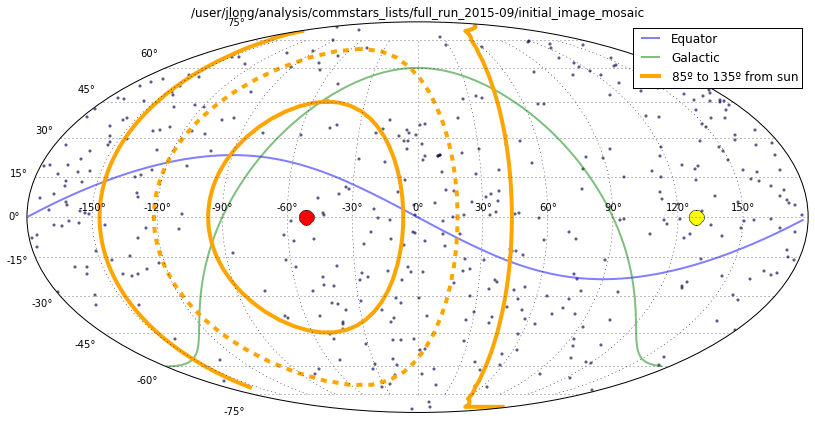

In [239]:
target_list = target_lists[0]
target_catalog = read_commstars(target_list)
plot_sky(target_catalog, '2018/08/01')
plt.title(target_list)

Sun RA =  8:44:34.53  Dec =  18:04:41.1
Sun l =  128:27:59.6  b =  -0:00:06.9


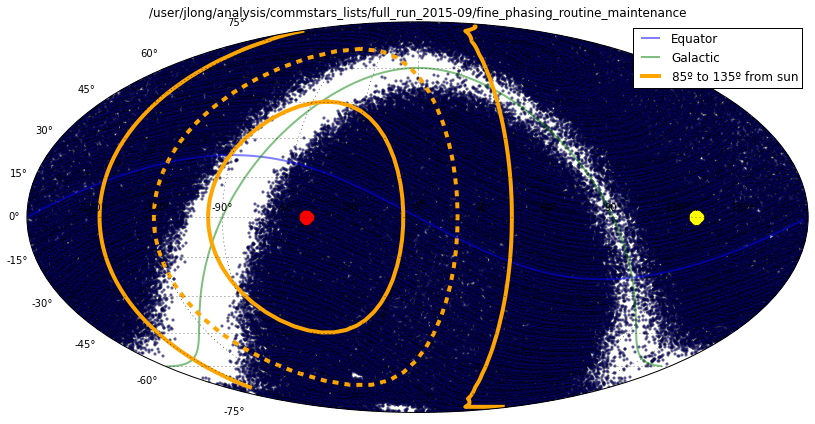

In [240]:
target_list = target_lists[1]
target_catalog = read_commstars(target_list)
plot_sky(target_catalog, '2018/08/01')
plt.title(target_list)

Sun RA =  12:28:31.60  Dec =  -3:04:50.1
Sun l =  187:30:48.4  b =  0:00:01.6


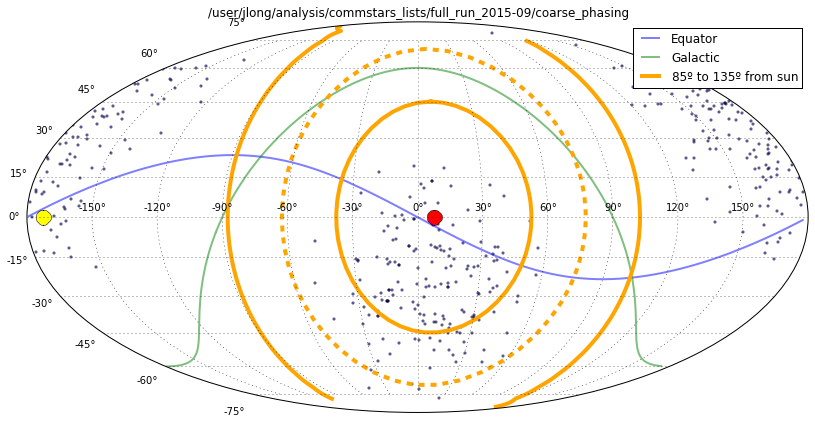

In [272]:
target_list = target_lists[2]
target_catalog = read_commstars(target_list)
plot_sky(target_catalog, '2018/10/01')
plt.title(target_list)

Sun RA =  8:44:34.53  Dec =  18:04:41.1
Sun l =  128:27:59.6  b =  -0:00:06.9


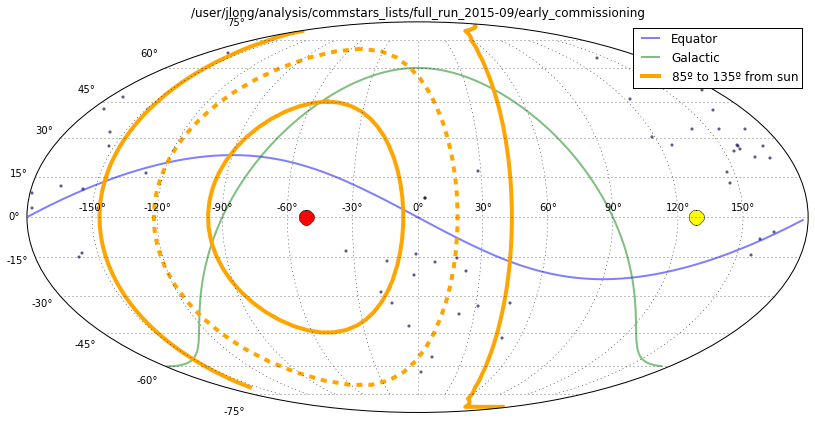

In [242]:
target_list = target_lists[3]
target_catalog = read_commstars(target_list)
plot_sky(target_catalog, '2018/08/01')
plt.title(target_list)

Sun RA =  8:44:34.53  Dec =  18:04:41.1
Sun l =  128:27:59.6  b =  -0:00:06.9


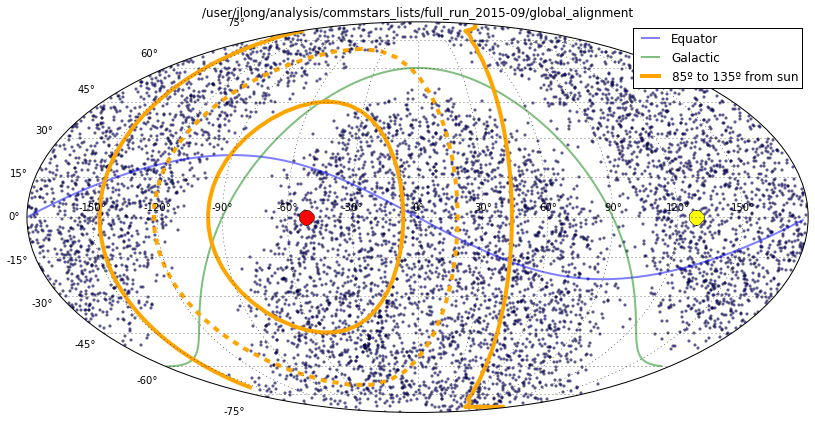

In [243]:
target_list = target_lists[4]
target_catalog = read_commstars(target_list)
plot_sky(target_catalog, '2018/08/01')
plt.title(target_list)

Sun RA =  8:44:34.53  Dec =  18:04:41.1
Sun l =  128:27:59.6  b =  -0:00:06.9


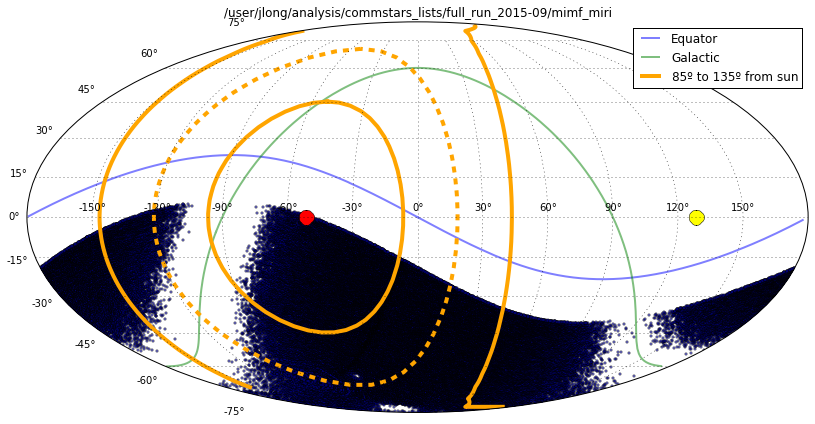

In [244]:
target_list = target_lists[5]
target_catalog = read_commstars(target_list)
plot_sky(target_catalog, '2018/08/01')
plt.title(target_list)